In [34]:
import numpy as np
import pandas as pd
import altair as alt

import geopandas as gpd
import json


# need to pip install pyproj
from pyproj import Proj
alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [35]:
# import os as os
# x = os.getcwd()
# x = x[:len(x)-3]

# geo_json_file_loc= x + "Data\local-area-boundary.geojson"
# def open_geojson():
#     with open(geo_json_file_loc) as json_data:
#         d = json.load(json_data)
#     return d

# def get_gpd_df():
#     vancouver_json = open_geojson()
#     gdf = gpd.GeoDataFrame.from_features((vancouver_json))
#     return gdf

# print(geo_json_file_loc)

# gdf = get_gpd_df()


C:\MyDisk\MDS\DSCI_532\grp_prjct\New\DSCI_532_Group114_SKEC\Data\local-area-boundary.geojson


In [37]:
# gdf
# mydata.groupby(by = 'NEIGHBOURHOOD').agg("count")
# gdf

In [9]:
# >>>>
# Creating Path to read data from the repo
import os as os
x = os.getcwd()
x = x[:len(x)-3]
path=x + "Data\crimedata_csv_all_years.csv"
# >>>>

In [10]:
# >>>>
# Reading Vancouver City Population from 2001 to 2018
path_pop=x + "Data\Population_trend.csv"
pop_yr = pd.read_csv(path_pop)
pop_yr = pop_yr[['YEAR', 'Population']]

# Reading each neighborhood's proportion of population to overall city's population
path_prop=x + "Data\population_proportion.csv"
pop_prop = pd.read_csv(path_prop)
# >>>>

In [11]:
mydata = pd.read_csv(path)
mydata.head()
print(mydata['TYPE'].value_counts())
print(mydata['NEIGHBOURHOOD'].value_counts())
print(mydata['YEAR'].value_counts())
mydata.info()

Theft from Vehicle                                        208877
Mischief                                                   83714
Break and Enter Residential/Other                          66266
Other Theft                                                64364
Offence Against a Person                                   61931
Theft of Vehicle                                           41462
Break and Enter Commercial                                 38807
Theft of Bicycle                                           31016
Vehicle Collision or Pedestrian Struck (with Injury)       25242
Vehicle Collision or Pedestrian Struck (with Fatality)       290
Homicide                                                     252
Name: TYPE, dtype: int64
Central Business District    136931
West End                      48597
Fairview                      36629
Mount Pleasant                36252
Grandview-Woodland            31535
Renfrew-Collingwood           31018
Kitsilano                     30580
Kensingt

In [38]:
# df2 = mydata.groupby(by = 'NEIGHBOURHOOD')['NEIGHBOURHOOD'].agg([('N', 'count')]).reset_index()
# gdf['NEIGHBOURHOOD'] = gdf['name']
# gdf = gdf.drop(columns="name")
# gdf = gdf.merge(df2, on='NEIGHBOURHOOD', how='inner')
# gdf

In [5]:
mydata = mydata[~((mydata['X']==0) | (mydata['Y']==0) | (mydata['NEIGHBOURHOOD'].isna()))]
mydata = mydata.drop(columns=['DAY', 'MINUTE', 'HUNDRED_BLOCK'])

# >>>>
# Excluding Year 2019 because the data is till Oct only whereas other years have full data
mydata = mydata[mydata['YEAR']!=2019]
# Relacing Stanley Park with West End because its a subset
mydata = mydata.replace({'NEIGHBOURHOOD': 'Stanley Park'}, value = 'West End')
# Relacing Musqueam with Marpole because its a subset
mydata = mydata.replace({'NEIGHBOURHOOD': 'Musqueam'}, value = 'Marpole')
# >>>>


# Converting XY UTM coordinate system to Latitude & Longitude
p = Proj(proj='utm',zone=10,ellps='WGS84', preserve_units=False)
lon, lat = p(mydata['X'].values, mydata['Y'].values, inverse=True)
latlon = pd.DataFrame(np.c_[lon, lat], columns=['Lon', 'Lat'])
mydata['Lon']=latlon['Lon']
mydata['Lat']=latlon['Lat']
mydata.head()

,TYPE,YEAR,MONTH,HOUR,NEIGHBOURHOOD,X,Y,Lon,Lat
0,Break and Enter Commercial,2012,12,8,Oakridge,491285.000000,5.453433e+06,-123.119712,49.233614
3,Break and Enter Commercial,2014,8,5,West End,491015.943352,5.459166e+06,-123.123461,49.285132
4,Break and Enter Commercial,2005,11,3,West End,491021.385727,5.459161e+06,-123.123461,49.285132
5,Break and Enter Commercial,2006,5,4,West End,491021.385727,5.459161e+06,-123.123311,49.285034
6,Break and Enter Commercial,2009,7,0,West End,491021.385727,5.459161e+06,-123.123311,49.285034


In [8]:
def charts(type_lst, ngbrhd_lst, yr_lst):
    df = mydata[(mydata['TYPE'].isin(type_lst)) & (mydata['NEIGHBOURHOOD'].isin(ngbrhd_lst)) & (mydata['YEAR'].isin(yr_lst))]
    
    MOY = df.groupby('MONTH')['MONTH'].agg([('N', 'count')]).reset_index().sort_values('MONTH', ascending=True)
    TOD = df.groupby('HOUR')['HOUR'].agg([('N', 'count')]).reset_index().sort_values('HOUR', ascending=True)
    type_crimes = df.groupby('TYPE')['TYPE'].agg([('N', 'count')]).reset_index().sort_values('N', ascending=False)
    type_crimes['contri'] = type_crimes['N']/sum(type_crimes['N'].values)

    crime_rate = df.groupby('YEAR')['YEAR'].agg([('N', 'count')]).reset_index().sort_values('YEAR', ascending=True)

    # >>>>
    # Adding population data to plot crime rate
    required_prop = sum(pop_prop[pop_prop['NEIGHBOURHOOD'].isin(ngbrhd_lst)]['proportion'].values)

    required_pop = pop_yr[pop_yr['YEAR'].isin(yr_lst)]
    required_pop['Population'] = required_pop['Population']*required_prop

    crime_rate = pd.merge(crime_rate, required_pop, how="inner", on="YEAR")
    crime_rate['rate'] = (crime_rate['N']/crime_rate['Population'])*1000
    # >>>>

    
    chart0 = alt.Chart(df).mark_point().encode(
        x=alt.X('Lon:Q', title='Longitude', scale=alt.Scale(domain=[np.min(df.Lon), np.max(df.Lon)])),
        y=alt.Y('Lat:Q', title='Latitude', scale=alt.Scale(domain=[np.min(df.Lat), np.max(df.Lat)])),
        color = 'NEIGHBOURHOOD:N'
    ).properties(
        width=700,
        height=400, 
        title = "Crimes In Vancouver"
    ).interactive()

    chart1 = alt.Chart(MOY).mark_bar().encode(
        x=alt.X('MONTH'),
        y=alt.Y('N', title='Occurrence Count')
    ).properties(
        width=350,
        height=300, 
        title = "Crime Occurrence By Month"
    )

    chart2 = alt.Chart(TOD).mark_bar().encode(
        x=alt.X('HOUR'),
        y=alt.Y('N', title='Occurrence Count')
    ).properties(
        width=350,
        height=300, 
        title = "Crime Occurrence By Time of Day"
    )

    # >>>>
    chart3 = alt.Chart(crime_rate).mark_line().encode(
        x=alt.X('YEAR:O'),
        y=alt.Y('rate', title='Occurrence Count')
    ).properties(
        width=350,
        height=300, 
        title = "Crime Rate (Crime Occurrences per 1000 people)"
    )
    # >>>>

    chart4 = alt.Chart(type_crimes).mark_bar().encode(
        x=alt.X('TYPE', 
                axis=alt.Axis(title=""),
                sort=alt.EncodingSortField(
                    field='contri',
                    order="descending"
                )),
        y=alt.Y('contri', axis=alt.Axis(title='Contribution', format='%'),)
    ).properties(
        title="Constituents on Selected Crimes",
        width=350,
        height=300
    )

    #test_dict = {'TYPE': df.TYPE.unique(), 'NEIGHBOURHOOD': df.NEIGHBOURHOOD.unique(), 'YEAR': df.YEAR.unique()}
    return((chart0) & ((chart1 & chart2) | (chart3 & chart4)))




C:\Users\Shivam\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


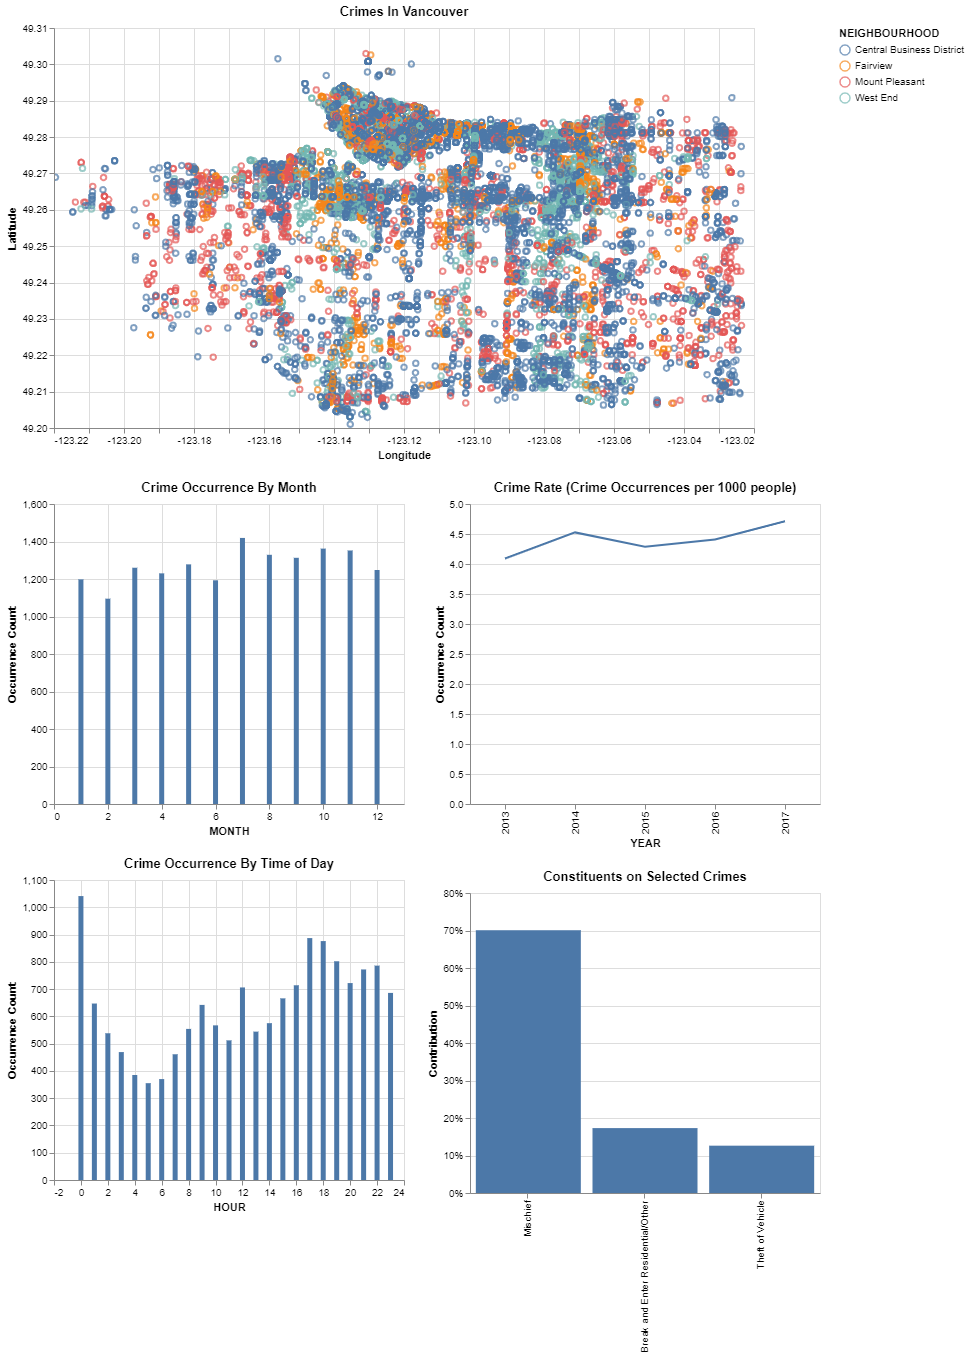

In [9]:
charts(['Mischief', 'Break and Enter Residential/Other', 'Theft of Vehicle'], ['Central Business District', 'West End', 'Fairview', 'Mount Pleasant'], list(np.arange(2013,2018,1)))